## Image caption generator 

- The idea of this project is to create a Deep Learning model that deliver textual description from given photographs. Thus a combination of different techniques from both __Computer Vision__ and __Natural Langue Processing__ are conducted. 
- I used pre-trained weight on _imagenet_ dataset of __Resnet50__ architecture to extract training features. Later __LSTM__ and __Reset50__ are combined as one deep CNN to train this caption generator model.
- The dataset used for this dataset can be downloaded from [Kaggle](https://www.kaggle.com/hsankesara/flickr-image-dataset).

## Before running this project

1. In order to execute this notebook, it is required to conduct several preprocessing stages and train the model in advance. Folder `/preprocess` contains python scripts with function described as below:
    - `extract_image_features.py`: extract features with pre-trained, fine-tune ResNet50 using Imagenet weight from training dataset. All features extracted are save as a pickle file `/preprocess/features.pkl`for later use (the file is not uploaded since it is too heavy)
    - `generate_tokenizer.py`: generate a tokenizer as pickle file `/preprocess/tokenizer.pkl`
    - `preprocess_text_data`: preprocess descriptions of every training image and save them as `/preprocess/descriptions.txt`

1. After obtaining 3 files `features.pkl`, `tokenizer.pkl`,`descriptions.txt` in folder `/preprocess`, run `train.py`to star training model. It should be notice that the training process consume lots of time and computational power (GPU and >8Gb is required). After the training is finished, the entire model and its weight would be save as file `image_captioning_model.h5` (this file is not uploaded since it is too heavy).


In [108]:
import glob
import pickle
from os.path import basename

import numpy as np
from keras.applications.resnet_v2 import preprocess_input
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [109]:
# load feature extrating model: ResNet50
def load_extract_features_model(extract_model_path):
    model = load_model(extract_model_path)
    return model

# extract feature from image using extracting model
def extract_features(filename, model):
    # load the models
    image = load_img(filename, target_size=(224,224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data
    image = np.expand_dims(image, axis=0)
    # preprocess image for model
    image = preprocess_input(image)
    # get features 
    feature = model.predict(image,verbose=0)
    return feature

In [110]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [111]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length)    :
    # seed the generation process
    in_text = "startseq"
    
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]        
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict nextword        
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [112]:
def return_description(filename, extract_model, model, tokenizer, max_length):
    # extract feature
    photo = extract_features(filename, extract_model)
    
    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    
    # remove "startseq" and "endseq"
    description = description.replace("startseq ","").replace(" endseq","")
    
    return description

In [113]:
extract_model_path = "./preprocess/ResNet50_feature_extraction.h5"
tokenizer_path = "./preprocess/tokenizer.pkl"
max_length = 34

# load the tokenizer
tokenizer = pickle.load(open(tokenizer_path,"rb"))
print("[INFO] Loading tokenizer successfully...")

# load extract feature mode
extract_model = load_extract_features_model(extract_model_path)
print("[INFO] Loading extracting feature model successfully...")

# load image captioning model
model = load_model('image_captioning_model.h5')
print("[INFO] Loading captioning model successfully...")

[INFO] Loading tokenizer successfully...


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[INFO] Loading extracting feature model successfully...
[INFO] Loading captioning model successfully...


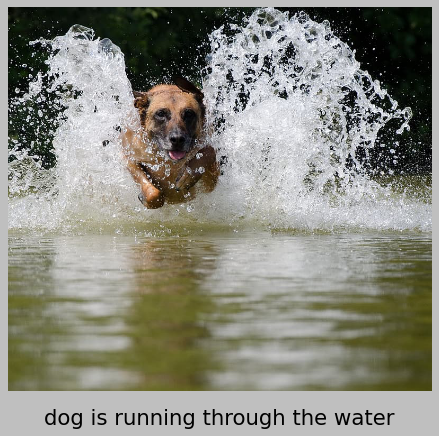

In [179]:
# test with a single image
test_image = "examples/figure_3.jpg"
# extract feature from image
photo = extract_features(test_image, extract_model)

# generate description
description = generate_desc(model, tokenizer, photo, max_length)

# remove "startseq" and "endseq"
description = description.replace("startseq ","").replace(" endseq","")

# visualize image with generated description
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,6))
plt.axis(False)
plt.imshow(load_img(test_image))
plt.title(description, y=-0.1)

#plt.savefig("dog_runnning.jpg", dpi=300)

[INFO] Find 6 images...


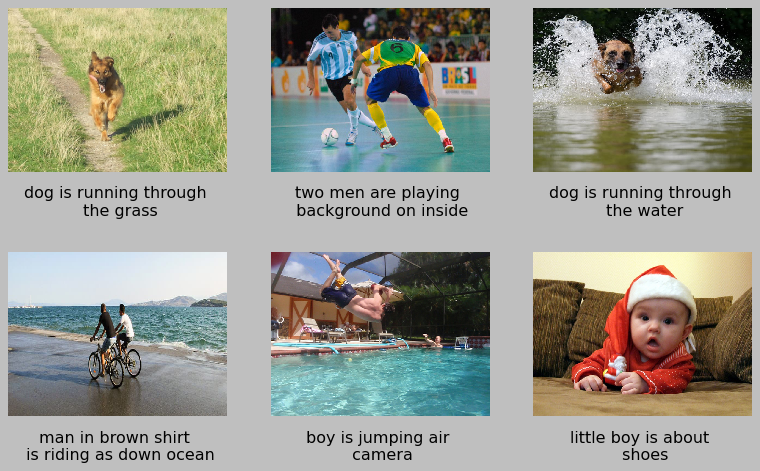

In [182]:
# test model with a group of images

def return_description(filename, extract_model, model, tokenizer, max_length):
    # extract feature
    photo = extract_features(filename, extract_model)
    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    # remove "startseq" and "endseq"
    description = description.replace("startseq ","").replace(" endseq","")
    
    # breakline of title
    for i, letter in enumerate(description):
        if (i > 15 and letter==" "):
            description = description[:i] +' \n' + description[i:]
            break
            
    return description

example_images = glob.glob("./examples/*.jpg")
print("[INFO] Find {:d} images...".format(len(example_images)))

fig = plt.figure(figsize=(12,7))
plt.rcParams.update({'font.size': 12})
grid = gridspec.GridSpec(ncols=3,nrows=2,figure=fig)

for i, image_path in enumerate(example_images):
    fig.add_subplot(grid[i])
    plt.axis(False)
    description = return_description(image_path,extract_model, model, tokenizer, max_length)
    plt.title(description,y=-0.3)
    img = load_img(image_path,target_size=(480,640))
    plt.imshow(img)

#plt.savefig("final_result.jpg", dpi=300)

## Conclusion
As you can see, the descriptions generated from example images are a bit confused although relate to image content. I did my model train my model for 27 epochs and the loss was halved compare to first epoch. However, it seems like I would need to train more epochs, maybe reduce learning rate and promote the complexity of the Neural Network.